**1. Try number of games:**

In [1]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="human")
observation, info = env.reset()
i = 0

while i < 2:
   action = env.action_space.sample()  # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)

   if truncated:
      observation, info = env.reset()
      i += 1
      print(f"Finish game number: {i}")

env.close()

print("Finish all the games.")

d:\environments\miniconda3\envs\env-rl\lib\site-packages\gymnasium\envs\classic_control\cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Finish game number: 1
Finish game number: 2
Finish all the games.


**2. Training**

In [97]:
import sys
import torch
import gymnasium as gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Constants
GAMMA = 0.9

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()

        # Number of elements in the action space
        self.num_actions = num_actions
        # Build a model of two layers
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        # Optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    
    def forward(self, state):
        '''
        Obtain the probabilities for each action based on the state
        '''
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x))
        return x
    
    def get_action(self, state):
        state = torch.from_numpy(state).float() # Preparae state
        probs = self.forward(Variable(state)) # Get the probabilities of using each action
        highest_prob_action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy())) # Randomly select 
        # an action taking into account the probability p -> This for the random nature of the policy
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action]) # Compute the log of the selected action
        return highest_prob_action, log_prob # return the randomly selected action based on the policy and its log

In [98]:
def update_policy(policy_network, rewards, log_probs):
    discounted_rewards = []

    # Calculate discounted rewards
    for t in range(len(rewards)):
        Gt = 0
        pw = 0
        for r in rewards[t:]:
            Gt += GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)

    # normalize discounted rewards
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

    # Calculate the policy_gradient
    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)

    policy_network.optimizer.zero_grad() # Start the NN
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward() # Derivate
    policy_network.optimizer.step() # Update theta

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_10820\4279040348.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.linear2(x))


episode: 0, total reward: 13.0, average_reward: 13.0, length: 12
episode: 1, total reward: 12.0, average_reward: 12.5, length: 11
episode: 2, total reward: 15.0, average_reward: 13.333, length: 14
episode: 3, total reward: 27.0, average_reward: 16.75, length: 26
episode: 4, total reward: 29.0, average_reward: 19.2, length: 28
episode: 5, total reward: 16.0, average_reward: 18.667, length: 15
episode: 6, total reward: 15.0, average_reward: 18.143, length: 14
episode: 7, total reward: 21.0, average_reward: 18.5, length: 20
episode: 8, total reward: 22.0, average_reward: 18.889, length: 21
episode: 9, total reward: 14.0, average_reward: 18.4, length: 13
episode: 10, total reward: 15.0, average_reward: 18.6, length: 14
episode: 11, total reward: 26.0, average_reward: 20.0, length: 25
episode: 12, total reward: 9.0, average_reward: 19.4, length: 8
episode: 13, total reward: 14.0, average_reward: 18.1, length: 13
episode: 14, total reward: 18.0, average_reward: 17.0, length: 17
episode: 15, 

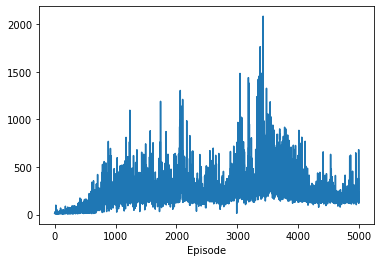

In [100]:
env = gym.make('CartPole-v0')

# Create the policy Network
policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128)

# Define the variables
max_episode_num = 5000
max_steps = 10000
numsteps = []
avg_numsteps = []
all_rewards = []

for episode in range(max_episode_num):
    state = env.reset()
    state = np.array(state[0])
    log_probs = []
    rewards = []

    for steps in range(max_steps):
        env.render()
        action, log_prob = policy_net.get_action(state)
        new_state, reward, done, _, _ = env.step(action)
        log_probs.append(log_prob)
        rewards.append(reward)

        if done:
            update_policy(policy_net, rewards, log_probs)
            numsteps.append(steps)
            avg_numsteps.append(np.mean(avg_numsteps[-10:]))
            all_rewards.append(np.sum(rewards))
            if episode % 1 == 0:
                sys.stdout.write("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
                break
        
        state = new_state
    
plt.plot(numsteps)
plt.plot(avg_numsteps)
plt.xlabel('Episode')
plt.show()

**3. Testing**

In [108]:
import gymnasium as gym

env = gym.make("CartPole-v0", render_mode="human")
observation, info = env.reset()
i = 0

while i < 2:
   current_state = np.array([observation])
   action, _ = policy_net.get_action(observation)  # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()
      current_state = np.array([observation])
      i += 1
      print(f"Finish game number: {i}")

env.close()

print("Finish all the games.")

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_10820\4279040348.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.linear2(x))


Finish game number: 1
Finish game number: 2
Finish all the games.
